# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
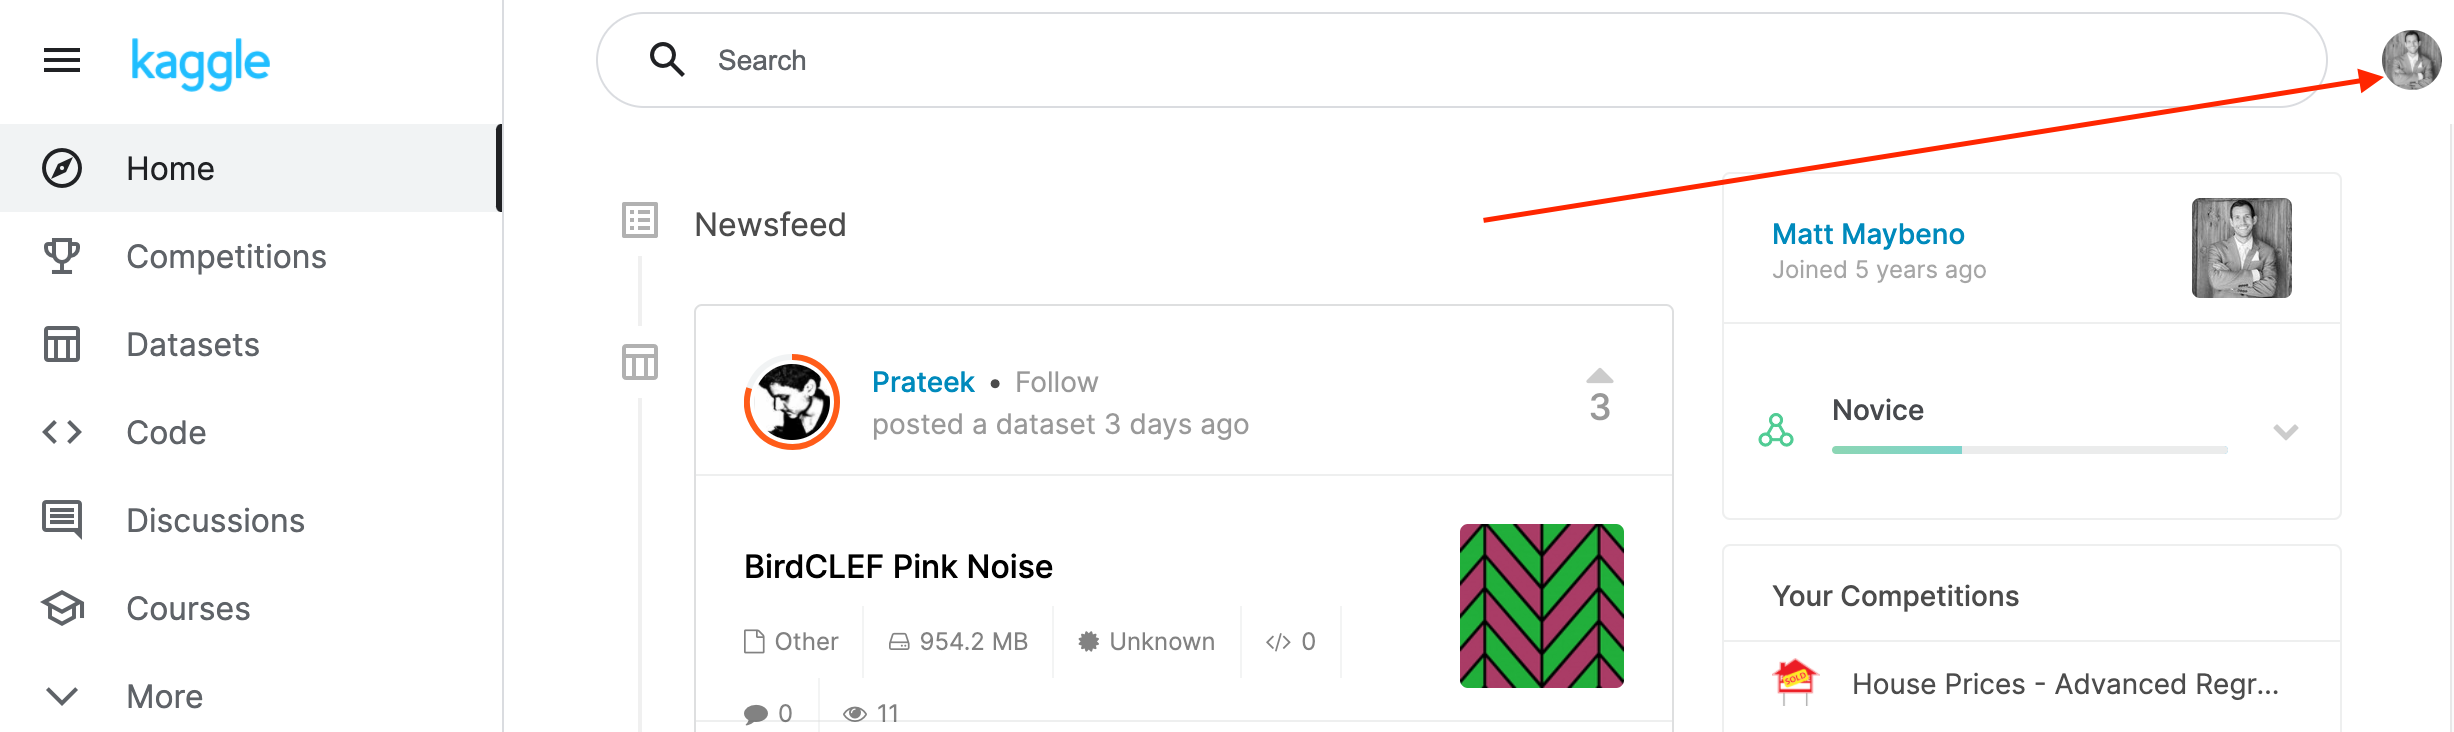
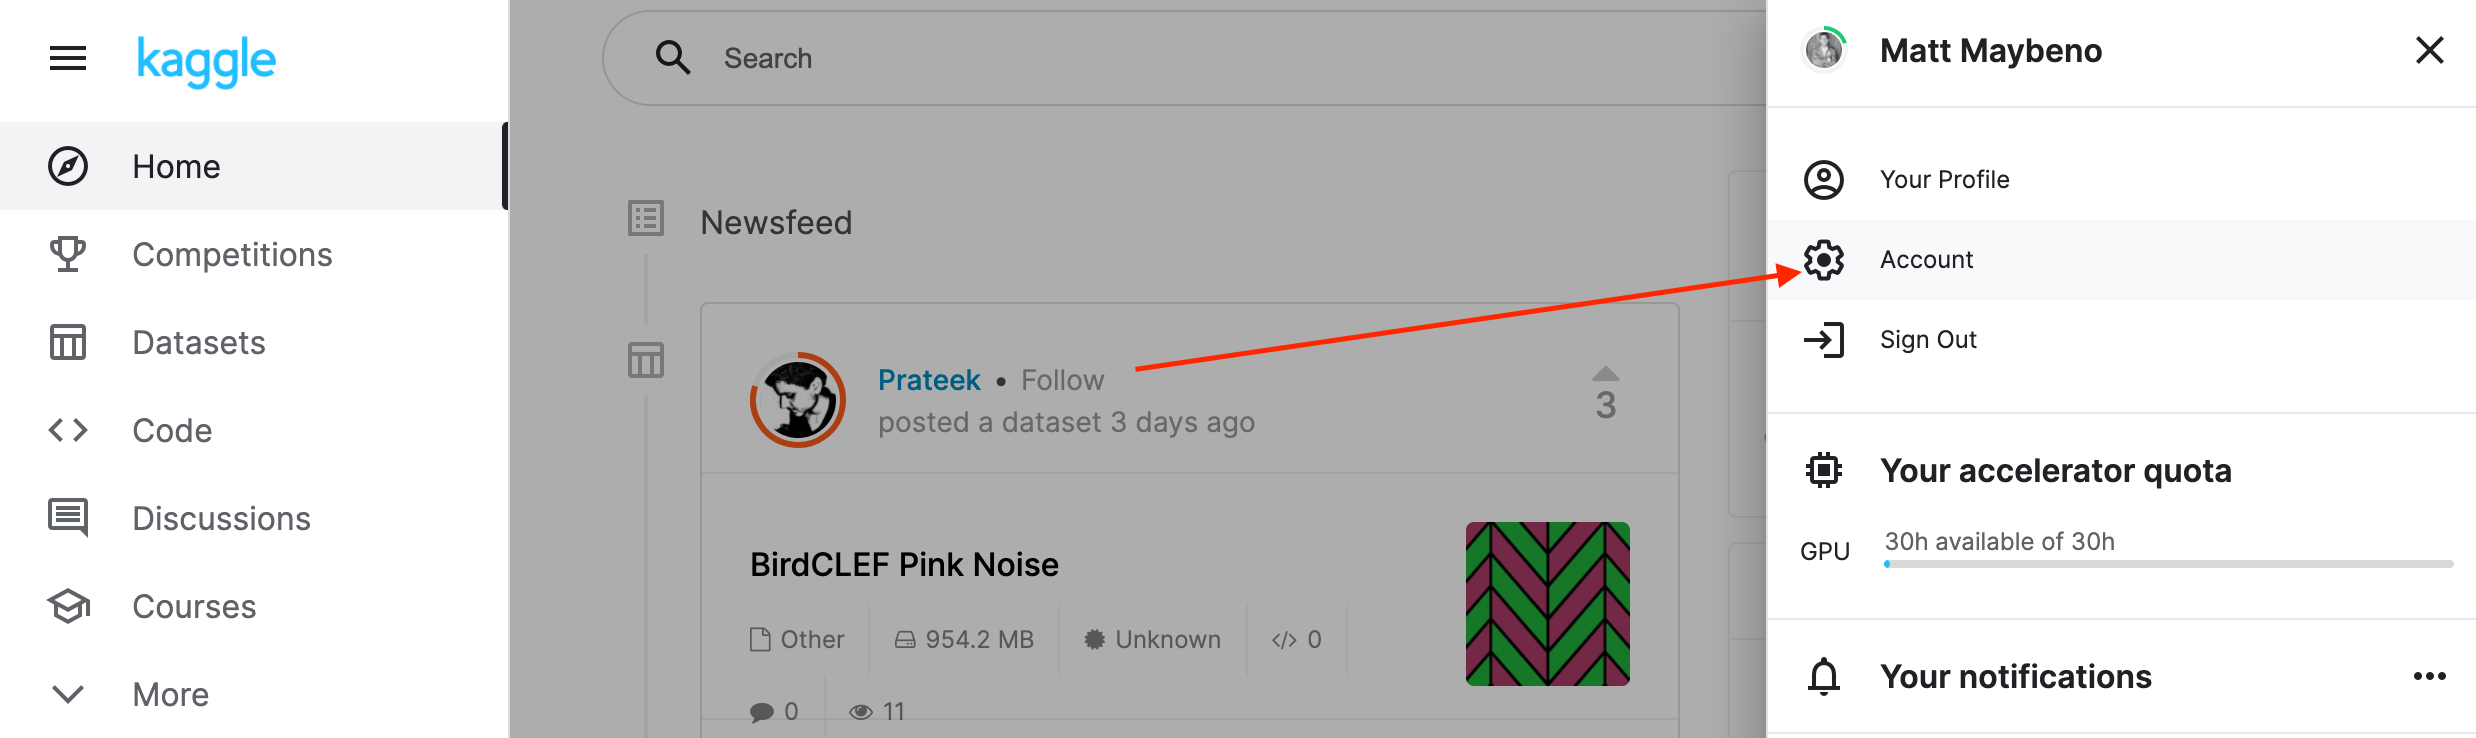
2. Scroll down to API and click Create New API Token.
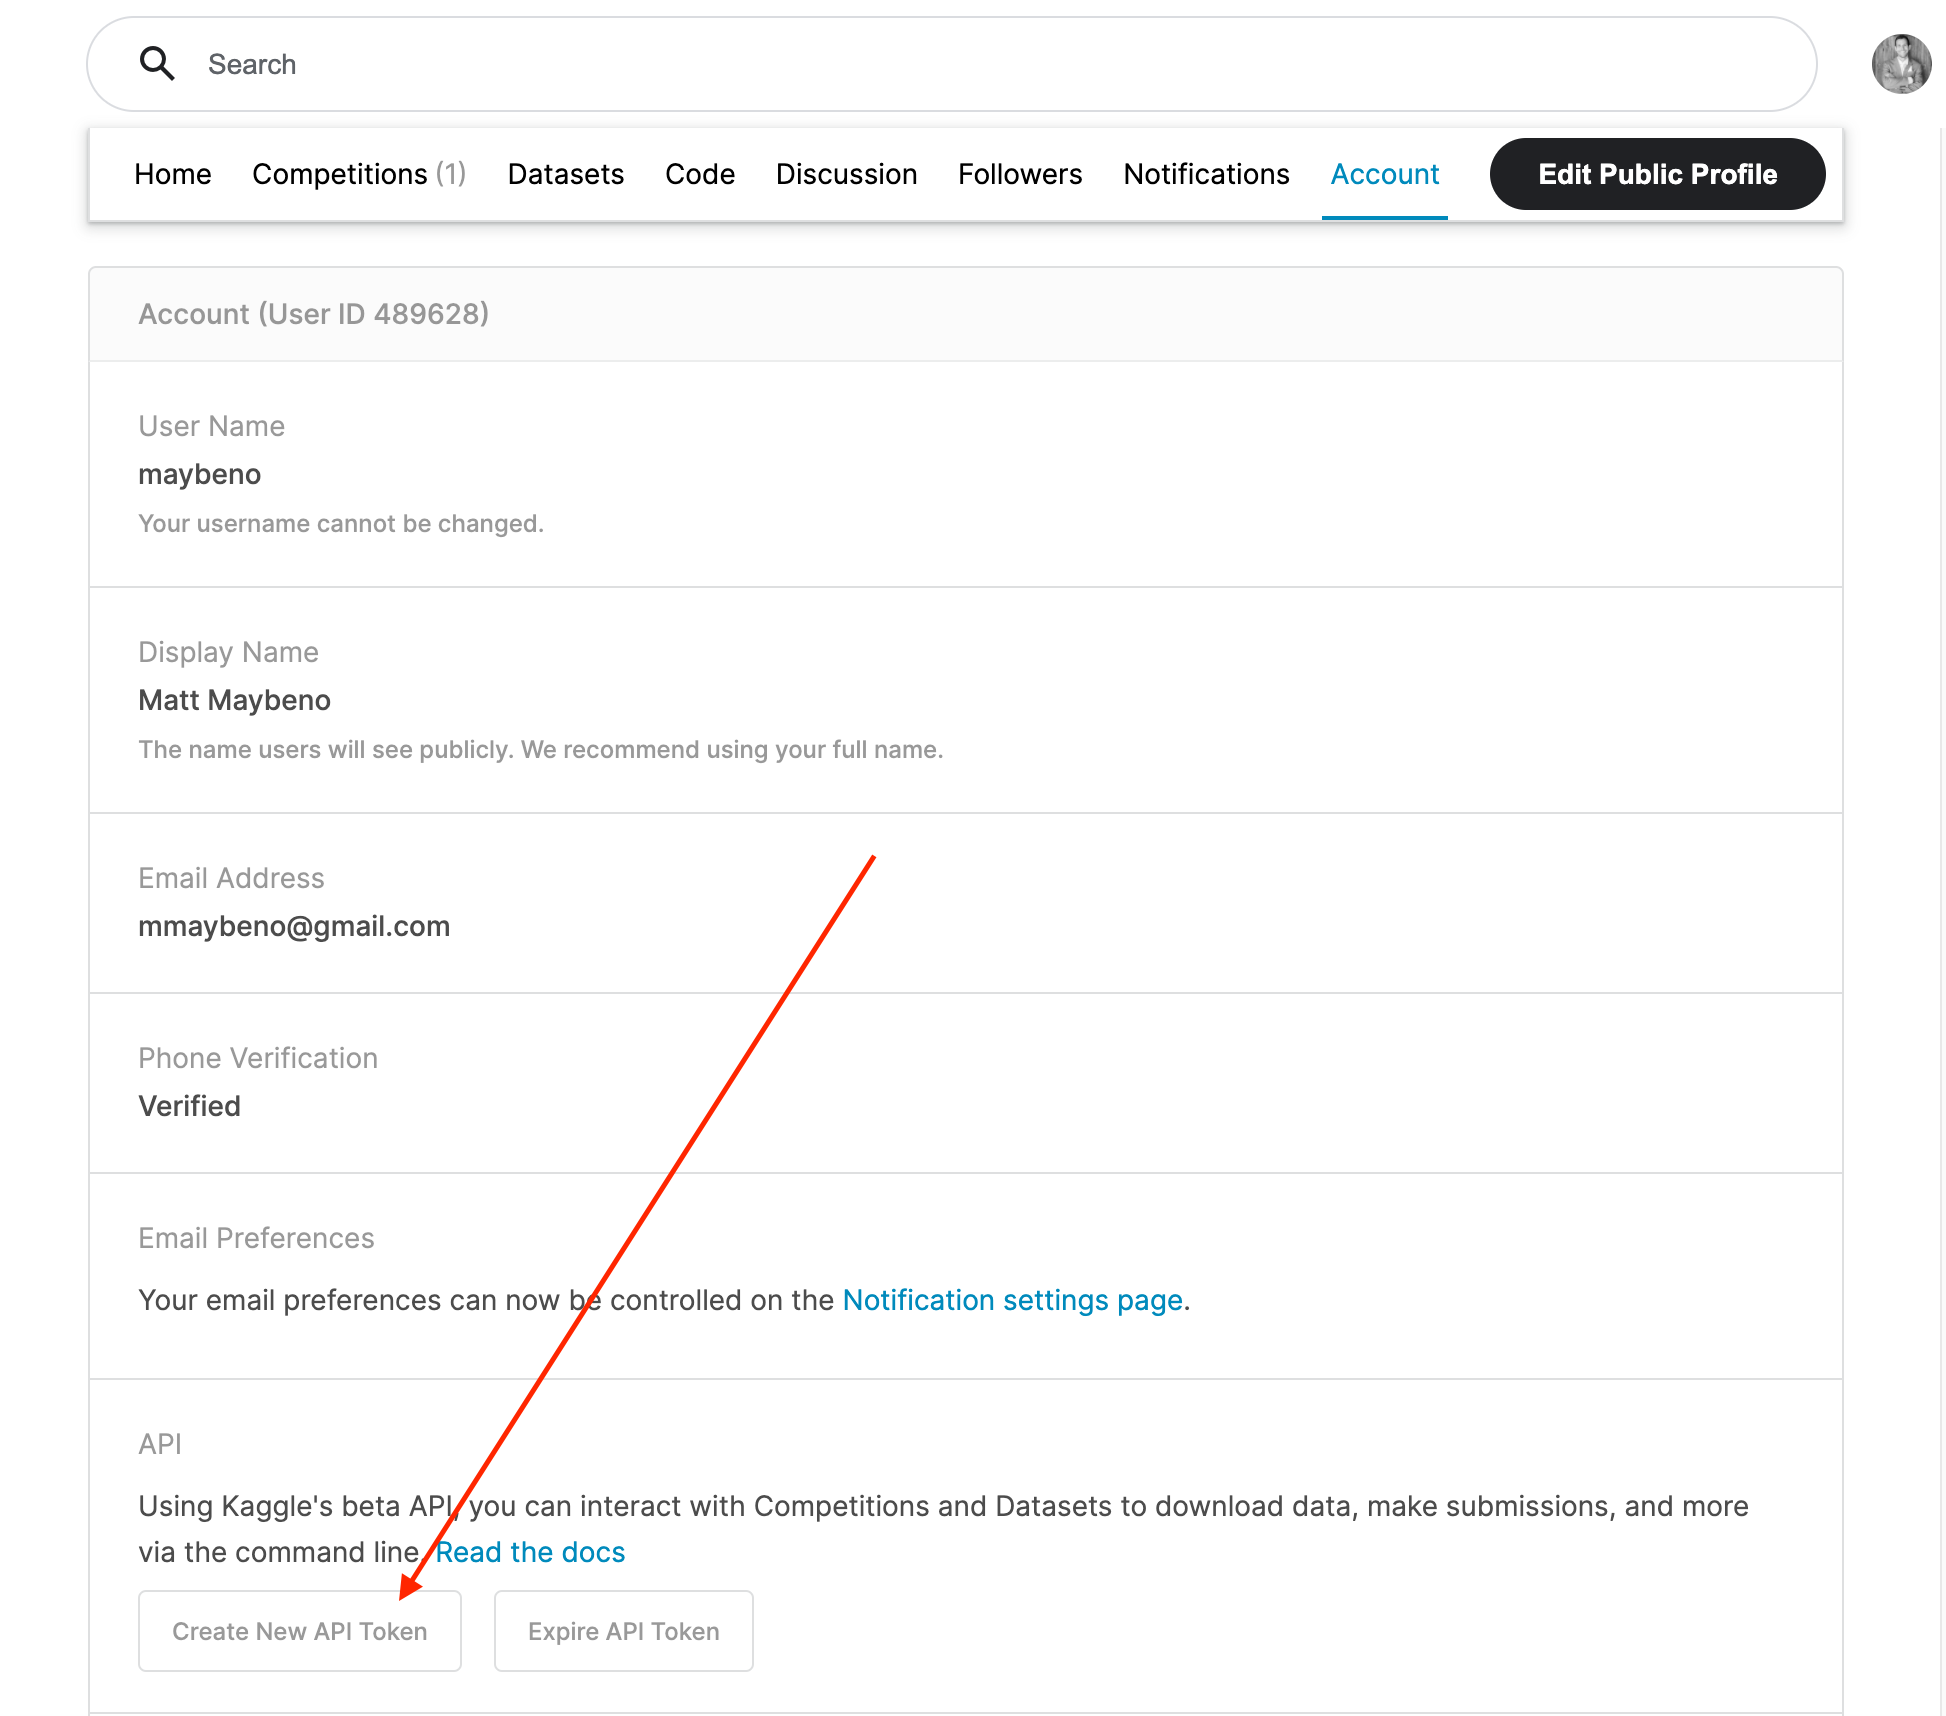
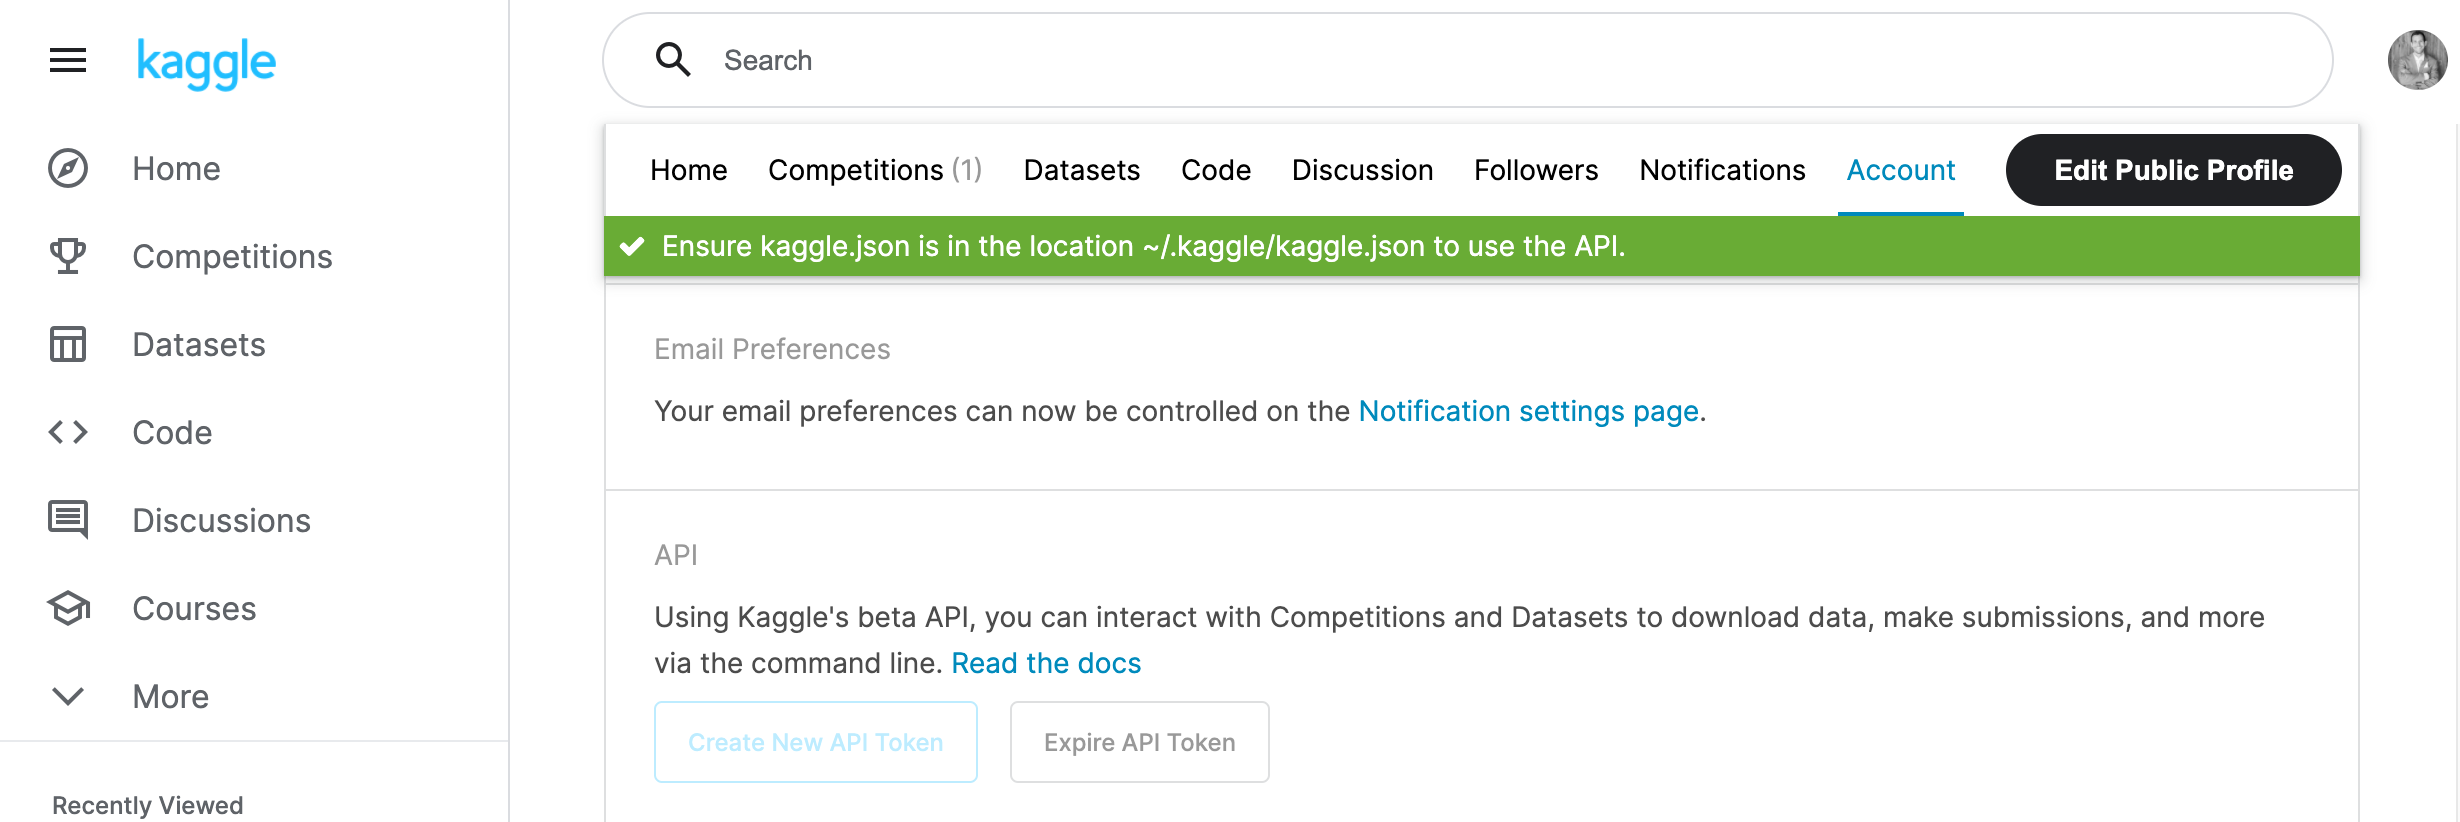
3. Open up `kaggle.json` and use the username and key.
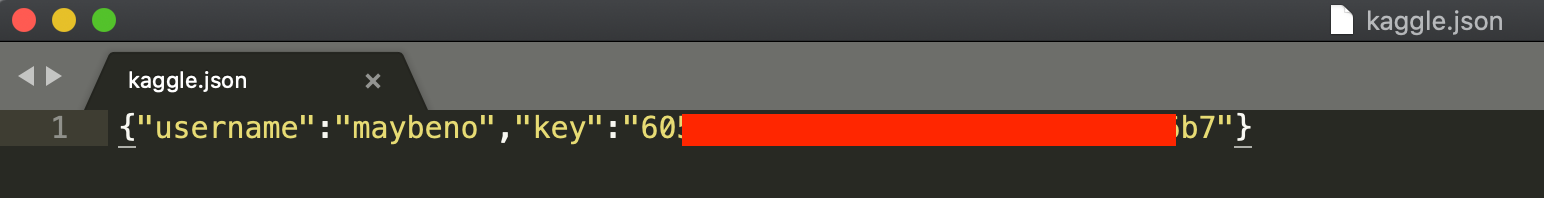

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "navidebra18"
kaggle_key = "990e0ecb199dc3df4daddf50e9b17c96"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms
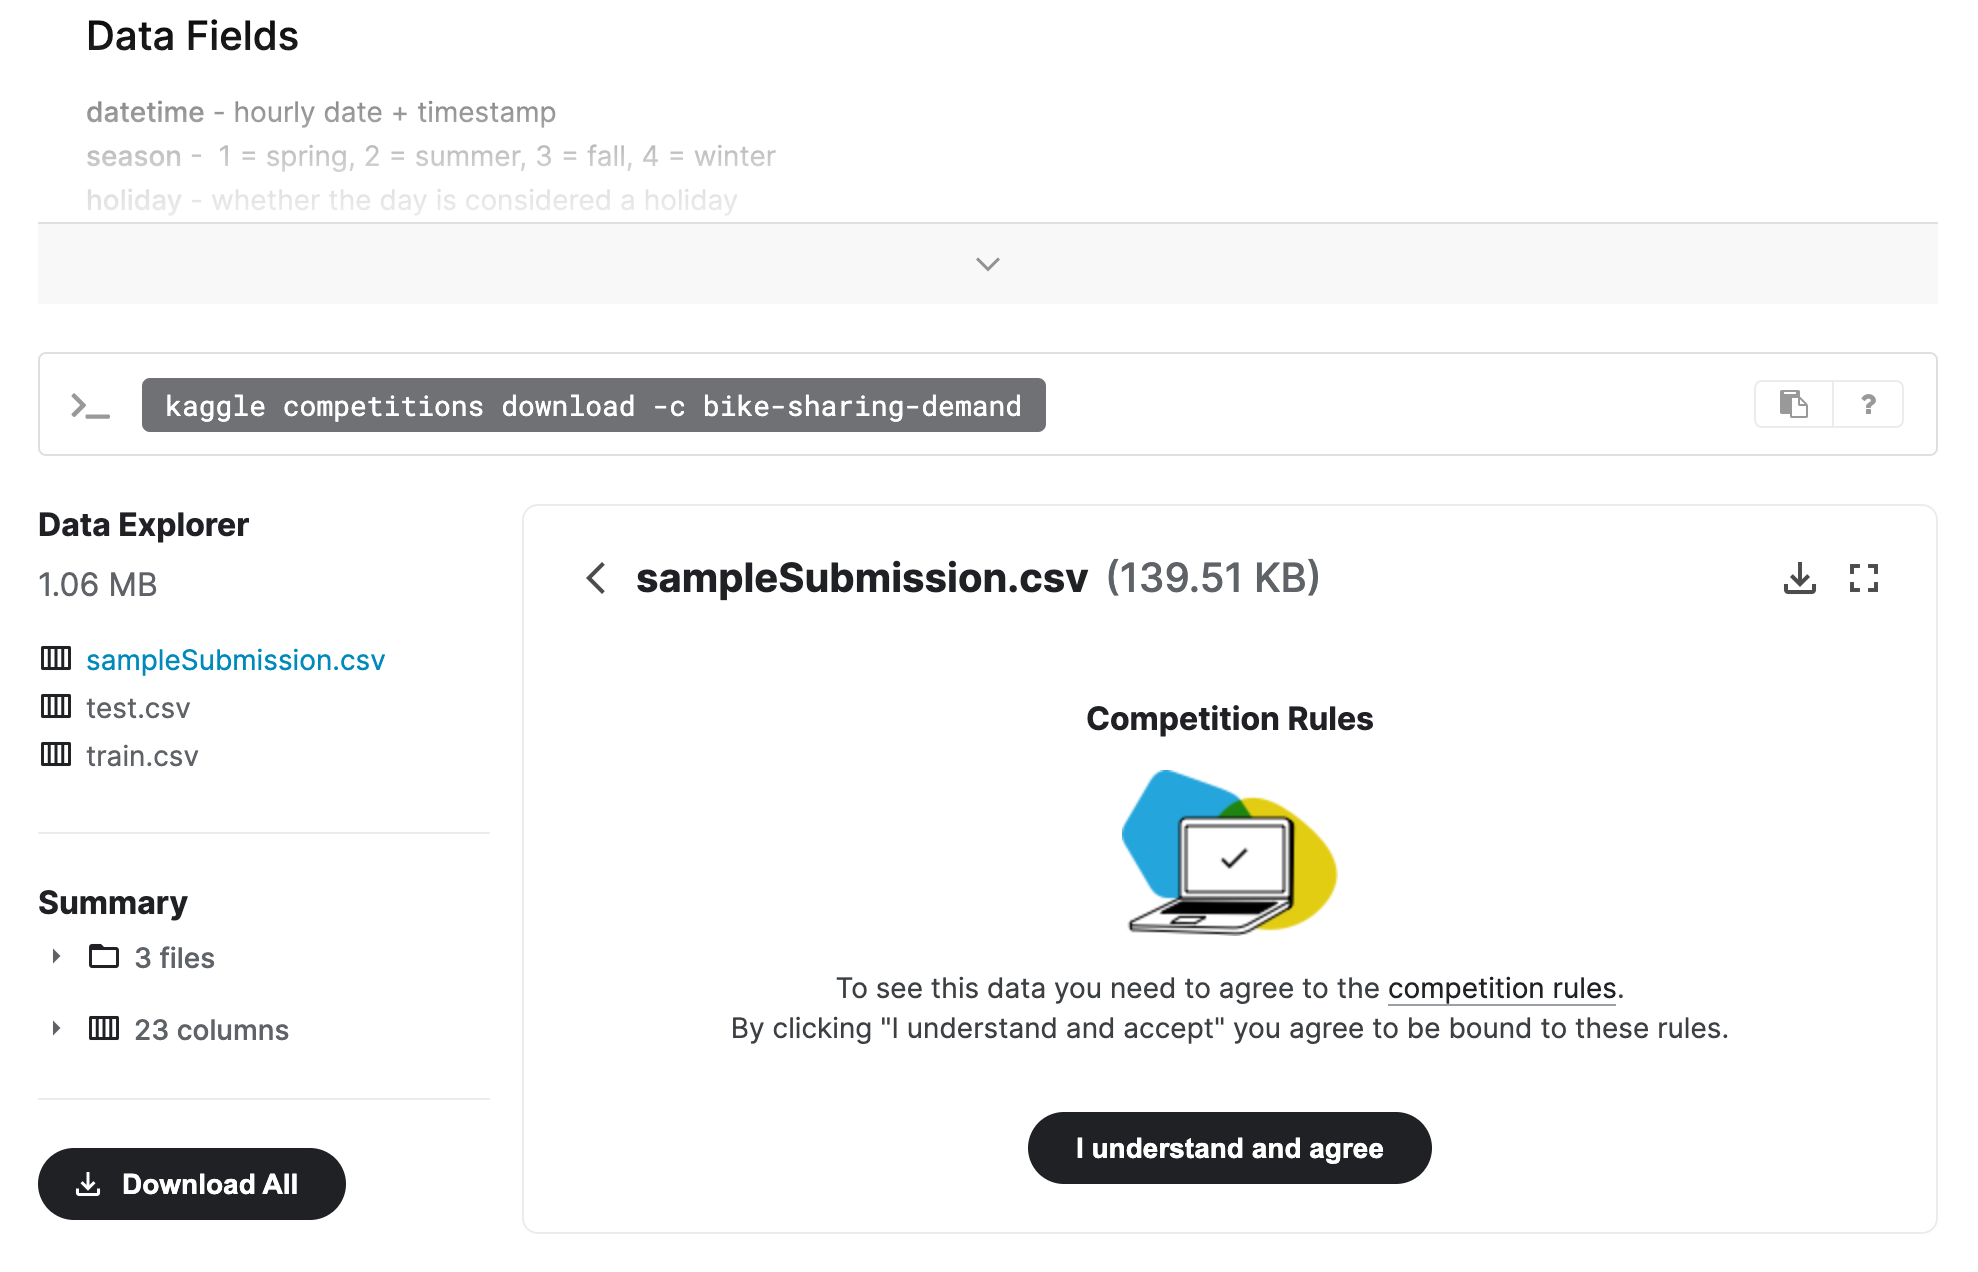

In [3]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from autogluon.common.space import Categorical, Int, Real
import seaborn as sb

In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [11]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [14]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error', learner_kwargs={'ignored_columns': ['registered', 'casual']},
                            ).fit(train_data=train,
                                   time_limit=600,
                                   presets='best_quality'
                                   )

No path specified. Models will be saved in: "AutogluonModels/ag-20240501_102204"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240501_102204/ds_sub_fit/sub_fit_ho.
2024-05-01 10:22:05,131	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.

### Review AutoGluon's training run with ranking of models that did the best.

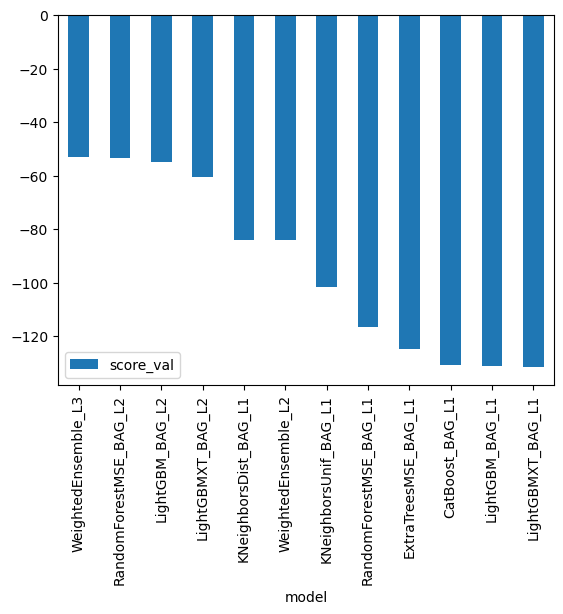

In [15]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val");

In [31]:
pd.DataFrame(predictor.fit_summary()['leaderboard']) # 53.12

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.124682  root_mean_squared_error      16.834831  385.340029                0.000599           0.078751            3       True         12
1   RandomForestMSE_BAG_L2  -53.464150  root_mean_squared_error      12.694785  294.177842                0.795754          41.938685            2       True         11
2          LightGBM_BAG_L2  -55.056261  root_mean_squared_error      12.265944  281.334336                0.366912          29.095179            2       True         10
3        LightGBMXT_BAG_L2  -60.390097  root_mean_squared_error      15.671566  314.227413                3.772535          61.988256            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.069305    0.086974   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.124682,root_mean_squared_error,16.834831,385.340029,0.000599,0.078751,3,True,12
1,RandomForestMSE_BAG_L2,-53.464150,root_mean_squared_error,12.694785,294.177842,0.795754,41.938685,2,True,11
2,LightGBM_BAG_L2,-55.056261,root_mean_squared_error,12.265944,281.334336,0.366912,29.095179,2,True,10
3,LightGBMXT_BAG_L2,-60.390097,root_mean_squared_error,15.671566,314.227413,3.772535,61.988256,2,True,9
4,KNeighborsDist_BAG_L1,-84.125061,root_mean_squared_error,0.069305,0.086974,0.069305,0.086974,1,True,2
5,WeightedEnsemble_L2,-84.125061,root_mean_squared_error,0.070722,0.131263,0.001418,0.044290,2,True,8
6,KNeighborsUnif_BAG_L1,-101.546199,root_mean_squared_error,0.047205,0.049065,0.047205,0.049065,1,True,1
7,RandomForestMSE_BAG_L1,-116.548359,root_mean_squared_error,0.555970,13.997348,0.555970,13.997348,1,True,5
8,ExtraTreesMSE_BAG_L1,-124.600676,root_mean_squared_error,0.791093,8.022465,0.791093,8.022465,1,True,7
9,CatBoost_BAG_L1,-130.849792,root_mean_squared_error,0.221768,128.521802,0.221768,128.521802,1,True,6


### Create predictions from test dataset

In [32]:
predictions = predictor.predict(test)
predictions.head()

0    22.530865
1    41.817886
2    45.508968
3    48.609322
4    51.710754
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [33]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.386688
std        89.914162
min         2.810693
25%        19.676195
50%        64.157722
75%       168.005188
max       369.828827
Name: count, dtype: float64

In [39]:
# How many negative values do we have?
(predictions == 0).sum()  # No Negative Values to replace with 0

0

### Set predictions to submission dataframe, save, and submit

In [36]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [37]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission 1"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 704kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [38]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-04-30 18:55:48  first raw submission 1             complete  1.80104      1.80104       
submission_new_features.csv  2024-04-30 18:55:13  new features 1                     complete  1.68211      1.68211       
submission_new_hpo.csv       2024-04-30 17:50:11  new features with hyperparameters  complete  1.78814      1.78814       
submission_new_hpo.csv       2024-04-30 17:29:05  new features with hyperparameters  complete  1.76913      1.76913       


#### Initial score of 1.80

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

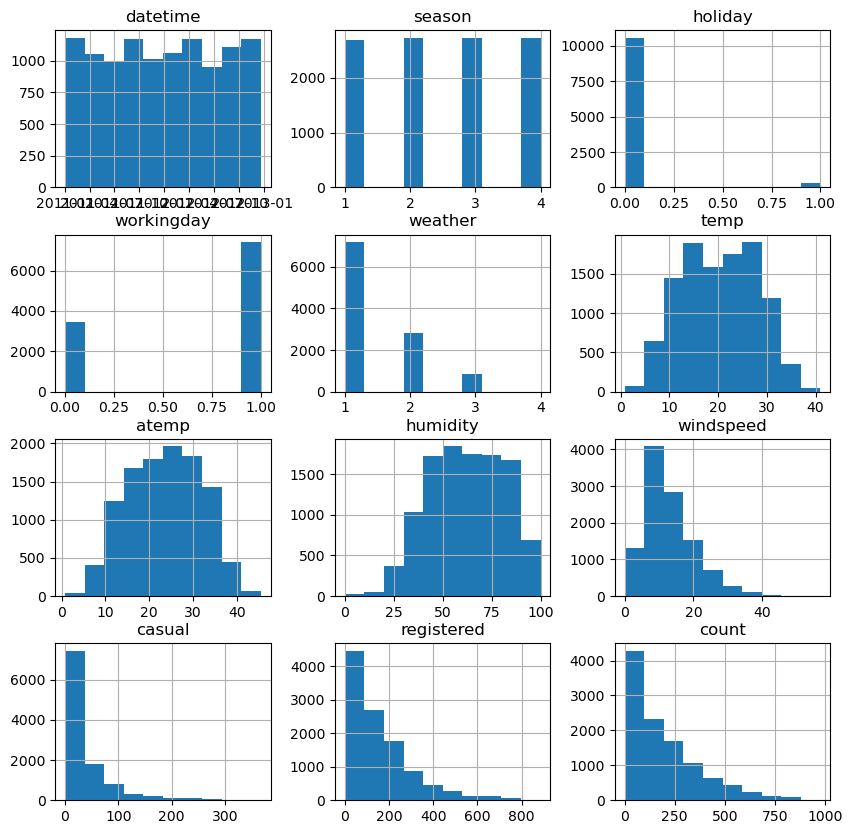

In [40]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(10, 10));

In [41]:
# create a new feature
train["year"] = train.datetime.dt.year
test["year"] = train.datetime.dt.year

train["month"] = train.datetime.dt.month
test["month"] = train.datetime.dt.month

train["hour"] = train.datetime.dt.hour
test["hour"] = train.datetime.dt.hour

In [51]:
import matplotlib.pyplot as plt

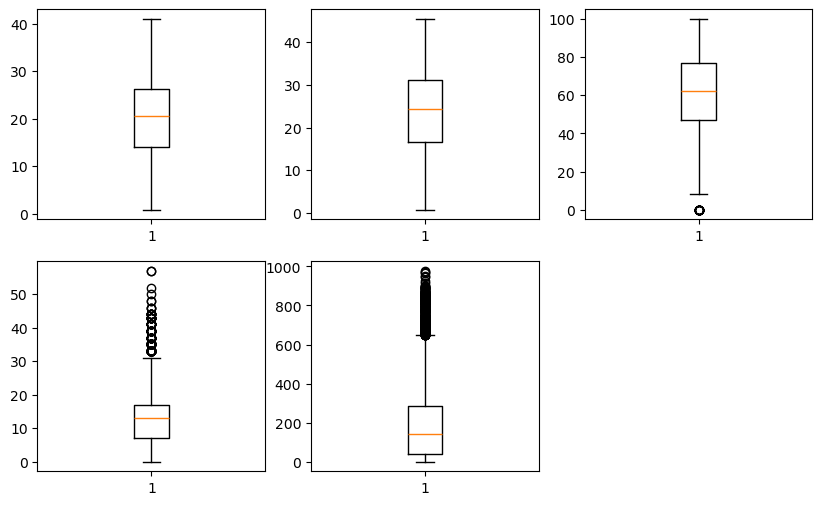

In [54]:
#Plotting box plot of continuous variables

plt.figure(figsize=(10, 6))
plt.subplot(2,3,1)
plt.boxplot(train["temp"])
plt.subplot(2,3,2)
plt.boxplot(train["atemp"])
plt.subplot(2,3,3)
plt.boxplot(train["humidity"])
plt.subplot(2,3,4)
plt.boxplot(train["windspeed"])
plt.subplot(2,3,5)
plt.boxplot(train["count"])
plt.show()

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [77]:
train[['season', 'weather']] = train[['season', 'weather']].astype('category')

test[['season', 'weather']] = test[['season', 'weather']].astype('category')

In [78]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4


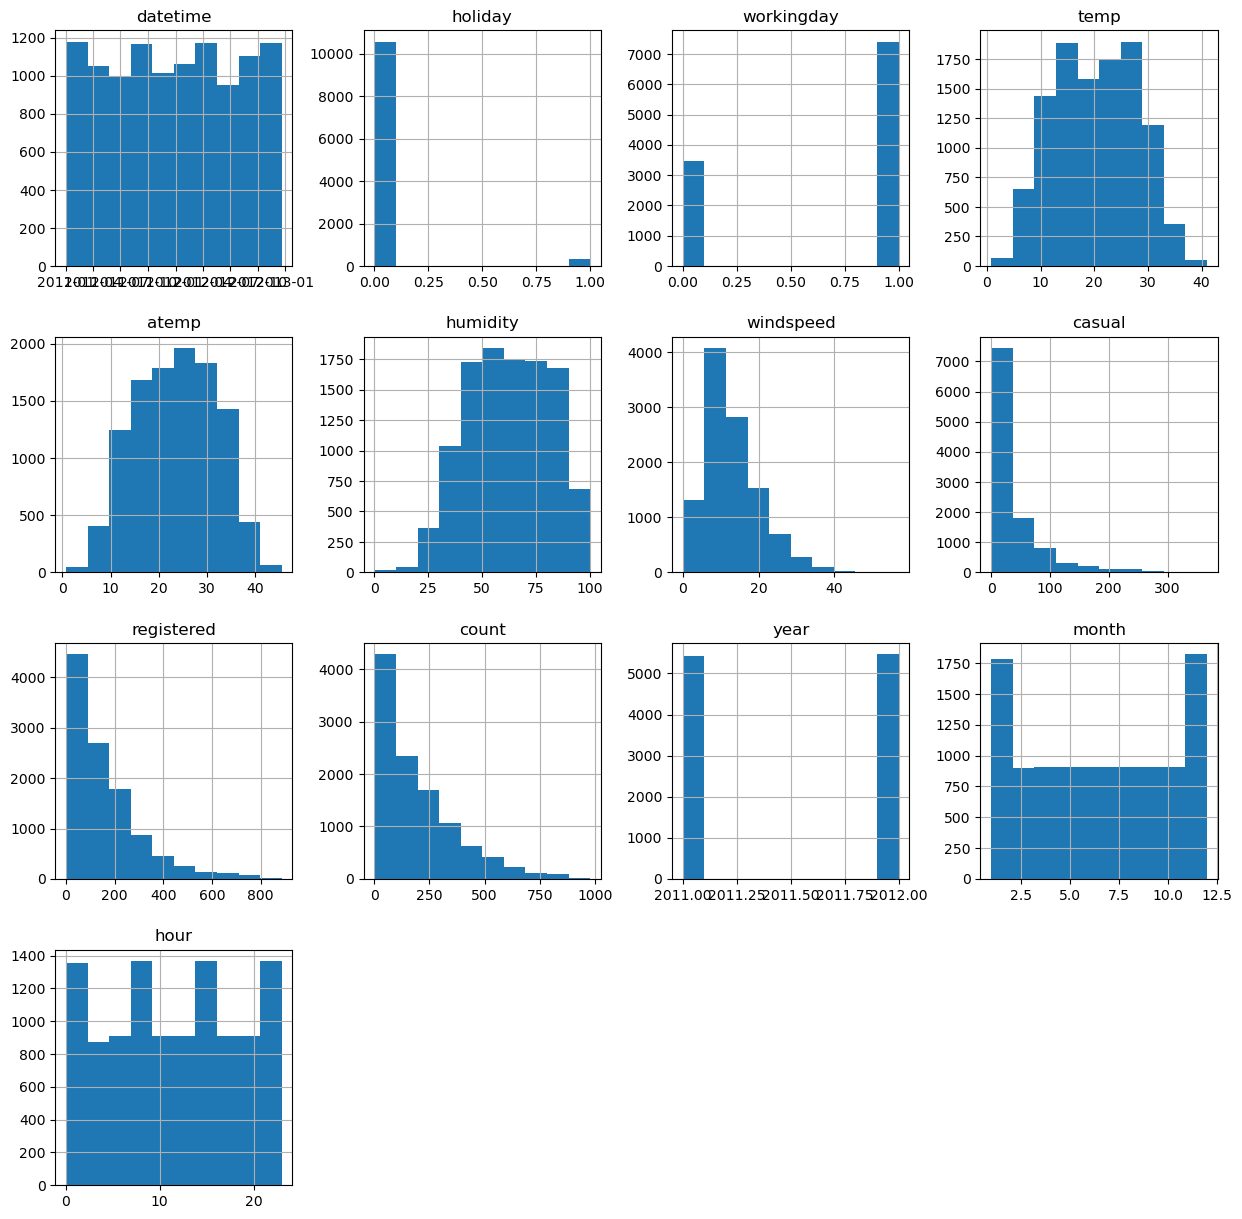

In [74]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15, 15));

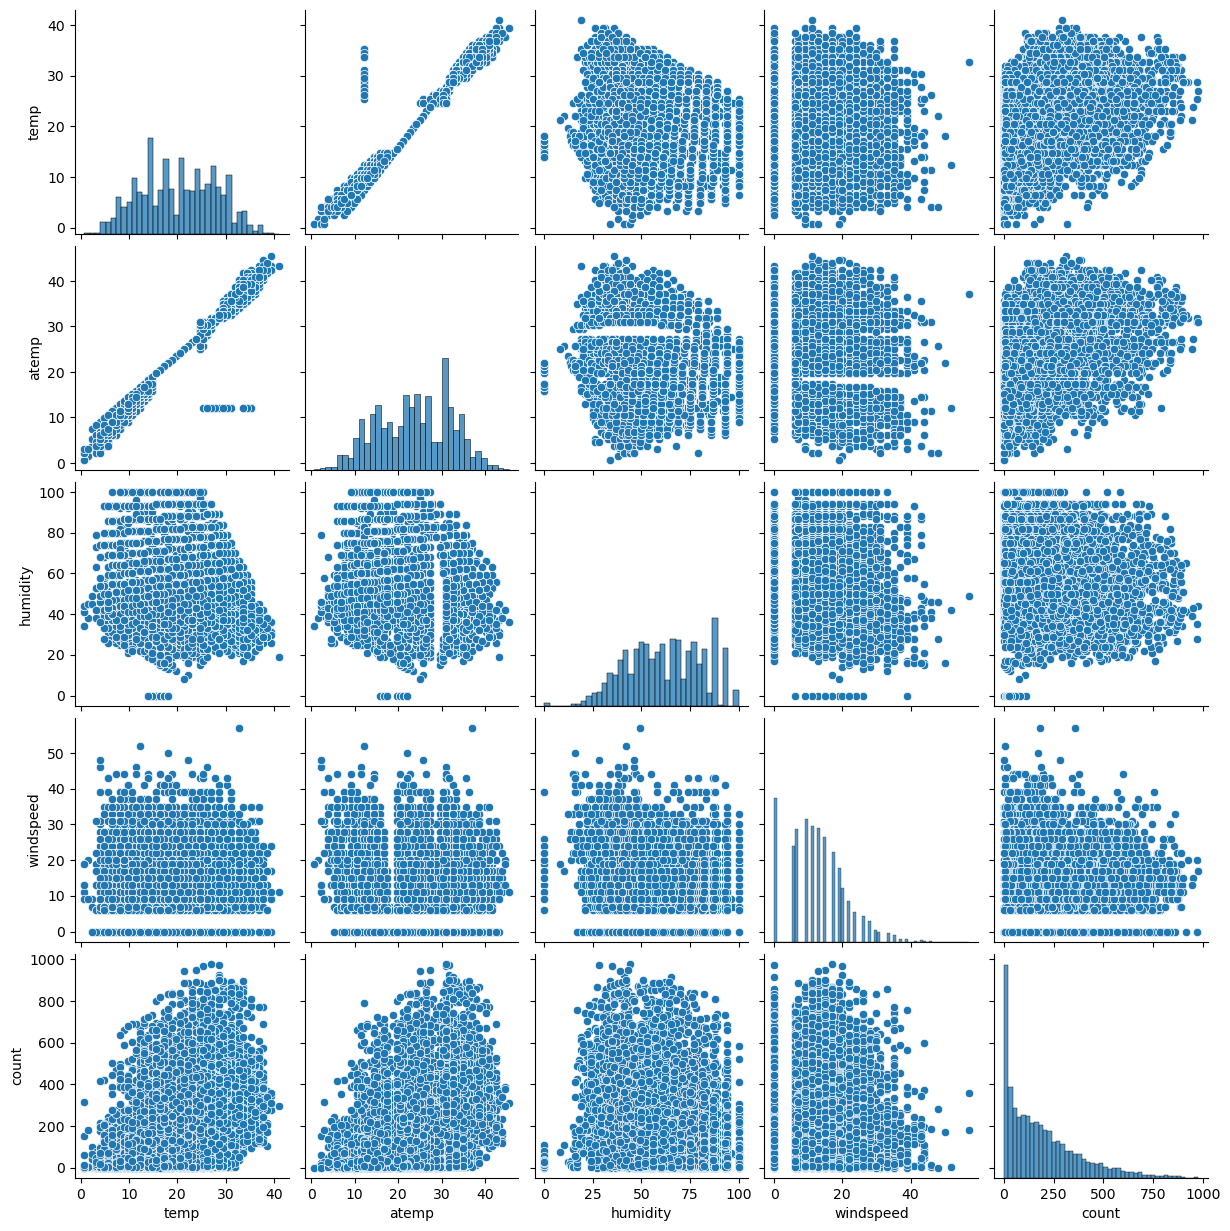

In [60]:
numerical_vals = ["temp","atemp","humidity","windspeed","count"]

#Plotting pairplot of all the numeric variables
sb.pairplot(train[numerical_vals]);
plt.show()

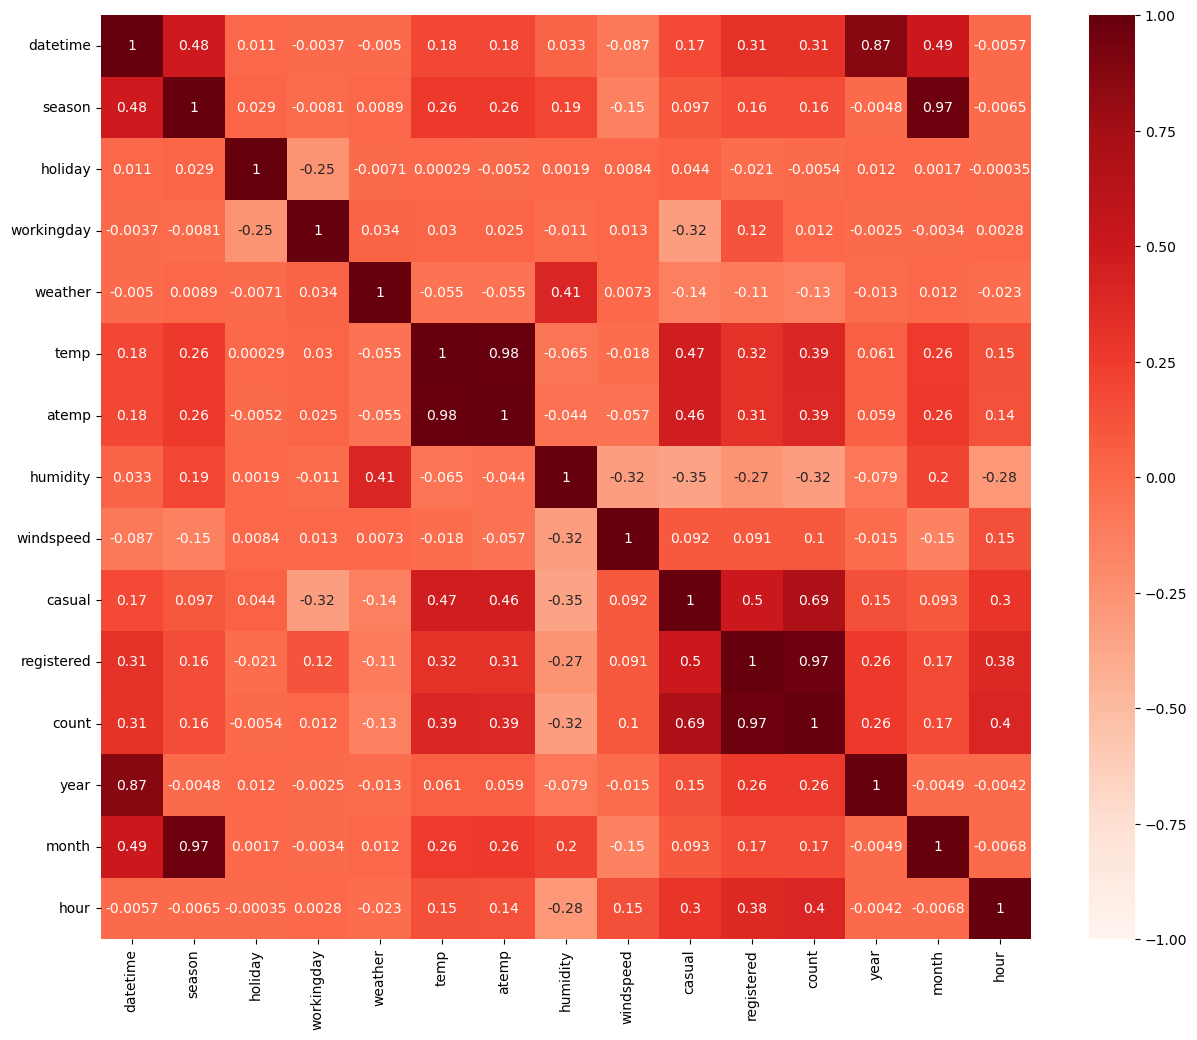

In [69]:
plt.figure(figsize = (15, 12))
sb.heatmap(train.corr(), vmin= -1, vmax=1, center=0, annot=True, cmap="Reds");

* Due to high correlation between atemp and temp, we'll only keep atemp which is Reel Feels of temperature.
* Also Datetime breakdown is present in year, month, hour columns so we'll exclude that as well.

## Step 5: Rerun the model with the same settings as before, just with more features

In [71]:
ignored_columns = ['casual', 'registered', 'temp', 'datetime']

In [79]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error', learner_kwargs={'ignored_columns': ignored_columns}
                                         ).fit(train_data=train,
                                               time_limit=600,
                                               presets='best_quality'
                                              )

No path specified. Models will be saved in: "AutogluonModels/ag-20240501_105642"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240501_105642/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 214 seconds

In [82]:
pd.DataFrame(predictor_new_features.fit_summary()['leaderboard']) # 37.91

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -37.917103  root_mean_squared_error      17.782887  324.247086                0.001453           0.045563            3       True         13
1      WeightedEnsemble_L2  -38.044416  root_mean_squared_error      16.586316  235.495844                0.002125           0.031789            2       True          8
2          CatBoost_BAG_L2  -38.314397  root_mean_squared_error      16.963664  271.628046                0.071249          36.036329            2       True         12
3          LightGBM_BAG_L2  -38.566592  root_mean_squared_error      17.033931  256.865034                0.141516          21.273317            2       True         10
4        LightGBMXT_BAG_L2  -38.992226  root_mean_squared_error      17.117783  259.202932   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-37.917103,root_mean_squared_error,17.782887,324.247086,0.001453,0.045563,3,True,13
1,WeightedEnsemble_L2,-38.044416,root_mean_squared_error,16.586316,235.495844,0.002125,0.031789,2,True,8
2,CatBoost_BAG_L2,-38.314397,root_mean_squared_error,16.963664,271.628046,0.071249,36.036329,2,True,12
3,LightGBM_BAG_L2,-38.566592,root_mean_squared_error,17.033931,256.865034,0.141516,21.273317,2,True,10
4,LightGBMXT_BAG_L2,-38.992226,root_mean_squared_error,17.117783,259.202932,0.225368,23.611215,2,True,9
5,RandomForestMSE_BAG_L2,-39.108623,root_mean_squared_error,17.568669,266.891877,0.676254,31.300160,2,True,11
6,LightGBMXT_BAG_L1,-39.277441,root_mean_squared_error,12.229211,76.397137,12.229211,76.397137,1,True,3
7,LightGBM_BAG_L1,-39.637461,root_mean_squared_error,2.997303,37.249106,2.997303,37.249106,1,True,4
8,CatBoost_BAG_L1,-40.245036,root_mean_squared_error,0.101793,105.015949,0.101793,105.015949,1,True,6
9,ExtraTreesMSE_BAG_L1,-41.842525,root_mean_squared_error,0.548593,5.270473,0.548593,5.270473,1,True,7


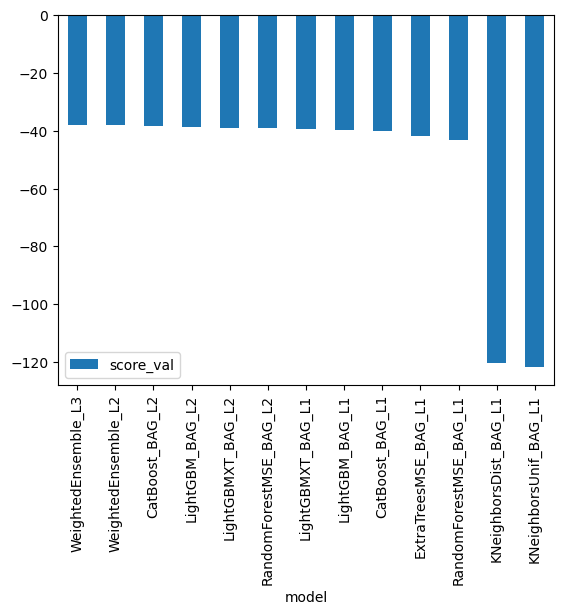

In [83]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val");

In [84]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)

In [85]:
(predictions_new_features < 0).sum()

25

In [86]:
predictions_new_features[predictions_new_features < 0] = 0

In [30]:
submission_new_features = pd.read_csv('sampleSubmission.csv')

In [31]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [34]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features 1"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 445kB/s]
Successfully submitted to Bike Sharing Demand

In [91]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-04-30 18:55:48  first raw submission 1             complete  1.80104      1.80104       
submission_new_features.csv  2024-04-30 18:55:13  new features 1                     complete  1.68211      1.68211       
submission_new_hpo.csv       2024-04-30 17:50:11  new features with hyperparameters  complete  1.78814      1.78814       
submission_new_hpo.csv       2024-04-30 17:29:05  new features with hyperparameters  complete  1.76913      1.76913       


#### New Score of 1.68

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [141]:
# GBM Models
gbm_params = [{'extra_trees': True, 
               #'num_boost_round': Int(lower=100, upper=800, default=100), 
               #'num_leaves': Int(lower=26, upper=66, default=36), 
               'ag_args': {'name_suffix': 'XT'}},'GBMLarge']


# CAT Models
cat_params = {"learning_rate": Real(lower=0.00001, upper=0.1, log=True),
              #"iterations": Int(lower=50, upper=1000),
              #"early_stopping_rounds": Int(lower=1, upper=10),
              #"depth": Int(lower=1, upper=10),
               }

# RandomForest Models
rf_params = {"max_depth": Int(lower=5, upper=10),
             #'max_features': Real(lower=0.1, upper=1.0),
             #'max_samples': Real(lower=0.1, upper=1.0)
            }

# Neural Network Models
nn_params = {'num_epochs': 10, 
             'batch_size': 32, 
             'activation':'relu',
            }

# XGB Models
xgb_params = {#'max_depth': Int(lower=3, upper=10, default=5), 
              'eta': Real(lower=0.1, upper=0.5),
              #'subsample': Real(lower=0.5, upper=1.0),
              'gamma': Int(lower=0, upper=5),
              # 'num_round': 100
             }

In [142]:
# hyperparameters of each model type
hyperparameters = {'GBM': gbm_params,
                   'CAT': cat_params,
                   'RF': rf_params,
                   'NN_TORCH': nn_params,
                   'XGB': xgb_params,
                  }  

In [ ]:
#'': 3 # number of different hyperparameter settings tested for each model
#'search_strategy': 'random', 'auto'
#'scheduler':'local'
# excluded_model_types = ['NN_TORCH']
# excluded_model_types=excluded_model_types
# num_stack_levels=2
# num_bag_folds=5, 
# num_bag_sets=1

In [146]:
predictor_new_hpo = TabularPredictor(label='count', 
                                     eval_metric='root_mean_squared_error', 
                                     problem_type='regression',
                                     learner_kwargs={'ignored_columns': ignored_columns}
                                    ).fit(train_data=train,
                                          hyperparameters=hyperparameters,
                                          hyperparameter_tune_kwargs={
                                              'scheduler' : 'local',
                                              'searcher': 'auto',
                                              'num_trials':3
                                          },
                                          time_limit=600,
                                          presets='best_quality',
                                         )

No path specified. Models will be saved in: "AutogluonModels/ag-20240501_123905"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240501_123905/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 168 seconds

  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.44%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	-39.4141	 = Validation score   (-root_mean_squared_error)
	70.85s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: RandomForest_BAG_L1 ... Tuning model for up to 43.18s of the 360.79s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

Fitted model: RandomForest_BAG_L1/T1 ...
	-105.1582	 = Validation score   (-root_mean_squared_error)
	3.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L1/T2 ...
	-53.0968	 = Validation score   (-root_mean_squared_error)
	5.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L1/T3 ...
	-48.275	 = Validation score   (-root_mean_squared_error)
	6.46s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 43.18s of the 344.61s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.44%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-180.5703	 = Validation score   (-root_mean_squared_error)
	49.41s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L1 ... Tuning model for up to 43.18s of the 294.95s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.65%)
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	-40.7284	 = Validation score   (-root_mean_squared_error)
	28.43s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 43.18s of the 266.35s of remaining time.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/trainer/abstract_trainer.py", line 2222, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1474, in hyperparameter_tune
    return self._hyperparameter_tune(hpo_executor=hpo_executor, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 184, in _hyperparam

  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.61%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L2/T1 ...
	-39.0383	 = Validation score   (-root_mean_squared_error)
	27.04s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: RandomForest_BAG_L2 ... Tuning model for up to 33.48s of the 195.93s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
Fitted model: RandomForest_BAG_L2/T1 ...
	-38.7521	 = Validation score   (-root_mean_squared_error)
	10.41s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L2/T2 ...
	-38.7832	 = Validation score   (-root_mean_squared_error)
	21.45s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 33.48s of the 163.83s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.75%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	-180.7816	 = Validation score   (-root_mean_squared_error)
	41.17s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L2 ... Tuning model for up to 33.48s of the 122.43s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.12%)
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L2/T1 ...
	-38.9146	 = Validation score   (-root_mean_squared_error)
	30.7s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L2 ... Tuning model for up to 33.48s of the 91.52s of remaining time.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/trainer/abstract_trainer.py", line 2222, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1474, in hyperparameter_tune
    return self._hyperparameter_tune(hpo_executor=hpo_executor, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 184, in _hyperparamet

In [149]:
pd.DataFrame(predictor_new_hpo.fit_summary()['leaderboard']) # 38.00

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -38.095203  root_mean_squared_error       2.200346  335.410149                0.001315           0.149913            3       True         15
1      WeightedEnsemble_L2  -38.258698  root_mean_squared_error       1.967257  137.123973                0.000735           0.024482            2       True          8
2   RandomForest_BAG_L2/T1  -38.752084  root_mean_squared_error       1.967678  212.736257                0.000176          10.411257            2       True         10
3   RandomForest_BAG_L2/T2  -38.783155  root_mean_squared_error       1.967698  223.777365                0.000196          21.452365            2       True         11
4        XGBoost_BAG_L2/T1  -38.914586  root_mean_squared_error       1.967659  233.029471   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-38.095203,root_mean_squared_error,2.200346,335.410149,0.001315,0.149913,3,True,15
1,WeightedEnsemble_L2,-38.258698,root_mean_squared_error,1.967257,137.123973,0.000735,0.024482,2,True,8
2,RandomForest_BAG_L2/T1,-38.752084,root_mean_squared_error,1.967678,212.736257,0.000176,10.411257,2,True,10
3,RandomForest_BAG_L2/T2,-38.783155,root_mean_squared_error,1.967698,223.777365,0.000196,21.452365,2,True,11
4,XGBoost_BAG_L2/T1,-38.914586,root_mean_squared_error,1.967659,233.029471,0.000157,30.704471,2,True,13
5,LightGBMXT_BAG_L2/T1,-39.038281,root_mean_squared_error,1.967651,229.368340,0.000149,27.043339,2,True,9
6,LightGBMLarge_BAG_L2,-39.386277,root_mean_squared_error,2.198351,245.648805,0.230849,43.323804,2,True,14
7,LightGBMXT_BAG_L1/T1,-39.414132,root_mean_squared_error,0.000162,70.846052,0.000162,70.846052,1,True,1
8,LightGBMLarge_BAG_L1,-39.821239,root_mean_squared_error,1.966216,37.825124,1.966216,37.825124,1,True,7
9,XGBoost_BAG_L1/T1,-40.728371,root_mean_squared_error,0.000144,28.428314,0.000144,28.428314,1,True,6


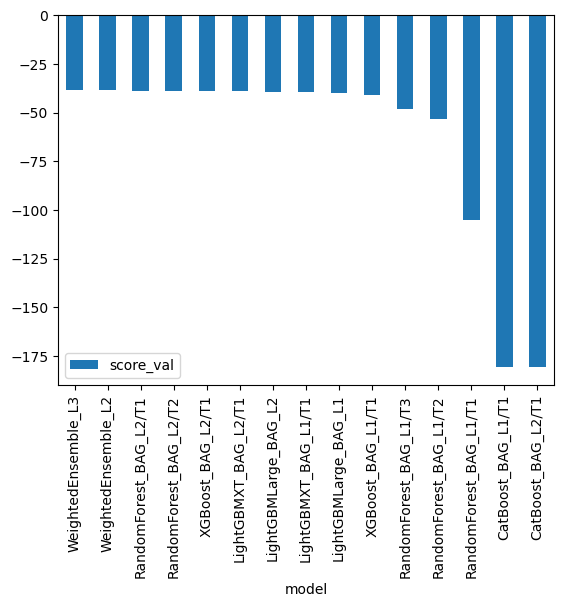

In [150]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val");

In [151]:
predictor_new_hpo = predictor_new_hpo.predict(test)

In [152]:
# Remember to set all negative values to zero
(predictor_new_hpo < 0).sum()

24

In [153]:
predictor_new_hpo[predictor_new_hpo < 0] = 0

In [121]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv')

In [122]:
# Same submitting predictions
submission_new_hpo["count"] = predictor_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [127]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters 2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 582kB/s]
Successfully submitted to Bike Sharing Demand

In [128]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-05-01 12:12:39  new features with hyperparameters 2  complete  1.81938      1.81938       
submission_new_hpo.csv       2024-04-30 21:44:07  new features with hyperparameters 1  complete  1.83521      1.83521       
submission.csv               2024-04-30 18:55:48  first raw submission 1               complete  1.80104      1.80104       
submission_new_features.csv  2024-04-30 18:55:13  new features 1                       complete  1.68211      1.68211       


#### New Score of 1.81

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

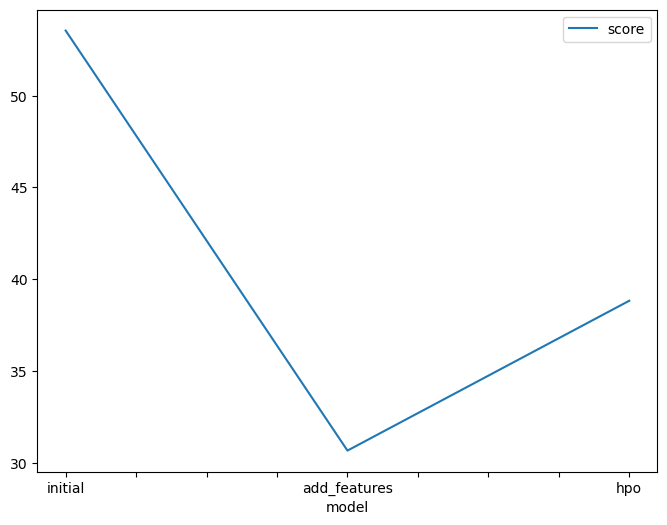

In [154]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [53.54, 30.67, 38.83]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

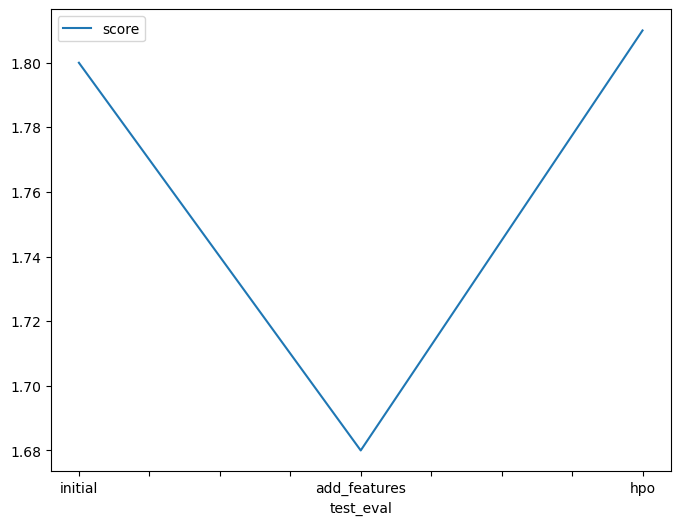

In [131]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80, 1.68, 1.81]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [156]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["Default", "Parsing Dates", "GBM, CAT, RF"],
    "hpo2": ["Default", "New columns Added", "NN_TORCH, XGB"],
    "hpo3": ["Default", "feature selection", "num_trials = 3"],
    "score": [1.80, 1.68, 1.83]
})

,model,hpo1,hpo2,hpo3,score
0,initial,Default,Default,Default,1.80
1,add_features,Parsing Dates,New columns Added,feature selection,1.68
2,hpo,"GBM, CAT, RF","NN_TORCH, XGB",num_trials = 3,1.83
